In [45]:
# Import libraries for data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for clustering and preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Import libraries for model training, evaluation, and cross-validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score)
from sklearn.pipeline import Pipeline

# Import SMOTE for handling class imbalance
from imblearn.over_sampling import SMOTE

In [46]:
#Perform data quality checks by checking for missing values, if any. 
#Understand what factors contributed most to employee turnover at EDA. 

In [47]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()
print(df.head())
df.info()

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years  sales  \
0                   3              0     1                      0  sales   
1                   6              0     1                      0  sales   
2                   4              0     1                      0  sales   
3                   5              0     1                      0  sales   
4                   3              0     1                      0  sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4 

In [48]:
# Check unique values in the 'sales' column as I see the dtype is object (categorical and not numerical which will pose issues in other processes)
print("Unique values in 'sales' column:")
print(df['sales'].unique())
print("Unique values in 'salary' column:")
print(df['salary'].unique())

Unique values in 'sales' column:
['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD']
Unique values in 'salary' column:
['low' 'medium' 'high']


In [49]:
# Before I can look at feature correlation with a heatmap, I see that I have two categories 'sales' and 'salary' that are objects.
# So I need to change to numeric.

# # Create a backup of the original department names because I will use this at the end
# Save a copy of the original department names
df_dept = df[['sales']].copy()  
# Optionally rename the column for clarity:
df_dept.rename(columns={'sales': 'department'}, inplace=True)



# ----- Convert 'sales' column to integer codes -----
# Departments in 'sales' are encoded as integers.
df['sales'] = df['sales'].astype('category')
df['sales'] = df['sales'].cat.codes

# ----- Convert 'salary' column to ordered integers -----
# Explicit mapping ensures the logical ordering: low < medium < high
salary_mapping = {"low": 0, "medium": 1, "high": 2}
df['salary'] = df['salary'].map(salary_mapping)

# Verify the conversion by printing the info and a sample of the data
print("\nData types after conversion:")
df.info()


Data types after conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  int8   
 9   salary                 14999 non-null  int64  
dtypes: float64(2), int64(7), int8(1)
memory usage: 1.0 MB


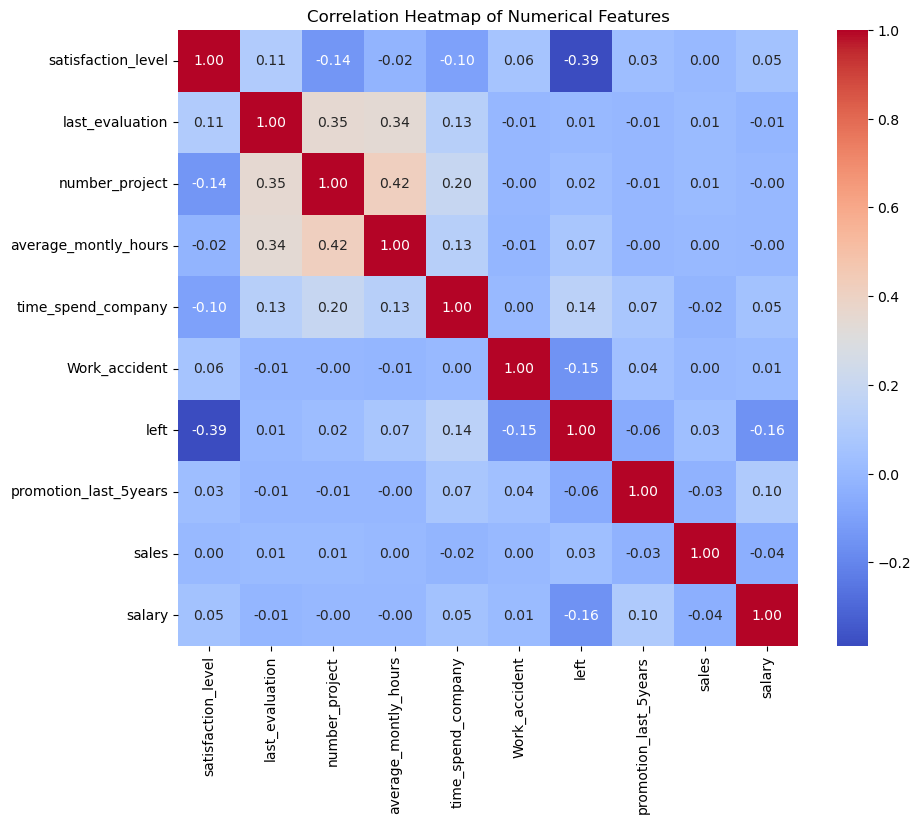

In [50]:
# Compute the correlation matrix for numerical features
corr_matrix = df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


In [51]:
# Observations from the heatmap:
# The only standout is satisfaction_level which is unfortunate because it's vague and doesn't speak to specific actionable items.
# Maybe need to look where satisfaction_level correlates with other feature values.
# There's a weak positive correlation with time_spend_company.  Which makes sense because the employee has already exhibited a propensity to not leave.
# The weak negative correlations are Work_accidents (no-brainer here) and salary.  
# Salary could point to an actionable item where the company should research current salary levels in the job market and make sure they're competitive.
# All the other features at .07 absolute value and less still need to be studies to see how they may interact with other variables.
# This suggests logistic regression or other classification methods need to be used to check for more complex interactions among features.

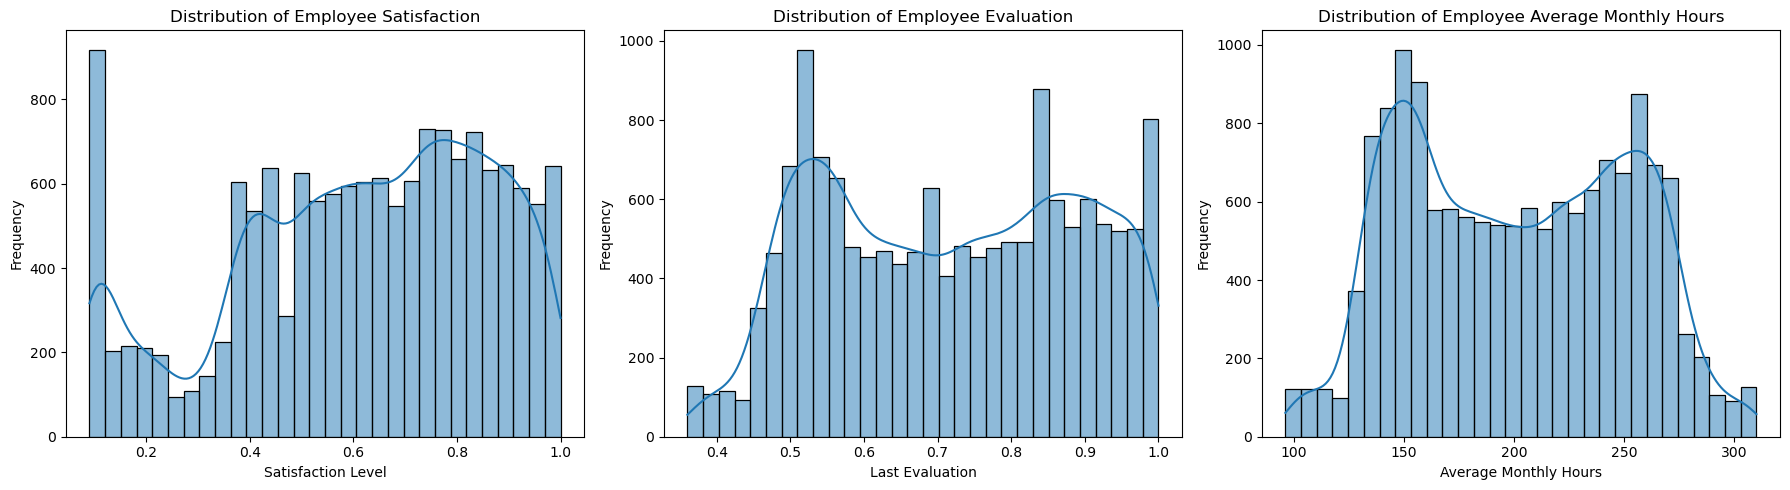

In [52]:
# since satisfaction_level shows the strongest correlation, I want to study a distribution of this feature to see if there are any insights
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

# Plot the Distribution of Employee Satisfaction
sns.histplot(df['satisfaction_level'], kde=True, bins=30, ax=axes[0])
axes[0].set_title('Distribution of Employee Satisfaction')
axes[0].set_xlabel('Satisfaction Level')
axes[0].set_ylabel('Frequency')

# Plot the Distribution of Employee Evaluation
sns.histplot(df['last_evaluation'], kde=True, bins=30, ax=axes[1])
axes[1].set_title('Distribution of Employee Evaluation')
axes[1].set_xlabel('Last Evaluation')
axes[1].set_ylabel('Frequency')

# Plot the Distribution of Employee Average Monthly Hours
sns.histplot(df['average_montly_hours'], kde=True, bins=30, ax=axes[2])
axes[2].set_title('Distribution of Employee Average Monthly Hours')
axes[2].set_xlabel('Average Monthly Hours')
axes[2].set_ylabel('Frequency')

# Spacing between plots
plt.tight_layout()

# Display the plots
plt.show()

# The x axis (frequency) shows how many employees fall into the each range of values for each plot: 
# Satisfaction level, Last Evaluation, and Average Monthly Hours
# Observations from first glance here seems to indicate that the very lowest satisfaction_level has the highest frequency of leaving.
# That is in line with the correlation we saw on the heatmap.
# How well the employees did on their last evaluation shows a trend for lower evaluation scores and higher chance of leaving.
# Aside from a couple spikes in the evaluation scores on the higher end, there is not too much correlation.
# The distribution for average monthly hours is the most interesting.  The tails on either end of monthly hours both show a trend for not leaving.
# So employees are working long hours and like their job and people are working less hours but still are not leaving.  
# The second and third quartiles show an inverse trend though.  Working less hours and employee might be disinterested in their work and should be predicted to leave.
# But the inverse is true after around 200 hours and those employees may be burning out and likely to leave.
# There are some outliers in last evaluation where the frequency spikes but not with the trend of the other bars

In [53]:
#Perform clustering of employees who left based on their satisfaction and evaluation. 
#Choose columns satisfaction_level, last_evaluation, and left. 
#Do K-means clustering of employees who left the company into 3 clusters? 
#Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters. 

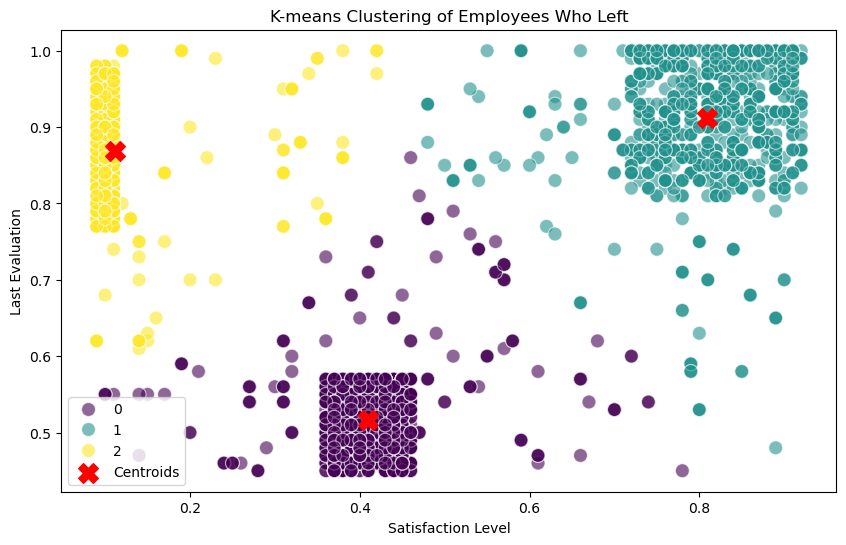

In [54]:
# Filter for employees who left
df_left = df[df['left'] == 1].copy()

# Select the relevant features for clustering:
# Although the instructions mention 'left', since it's constant (all ones) in this subset,
# I only need to use 'satisfaction_level' and 'last_evaluation' for the clustering.
X = df_left[['satisfaction_level', 'last_evaluation']].values

# Apply K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# Retrieve the cluster labels and cluster centroids
cluster_labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add the cluster labels back to the dataframe for later analysis and plotting
df_left['cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_left, 
    x='satisfaction_level', 
    y='last_evaluation', 
    hue='cluster', 
    palette='viridis', 
    s=100, 
    alpha=0.6
)
# Plot the cluster centroids
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('K-means Clustering of Employees Who Left')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend()
plt.show()

# observations from cluster below:
# clearly if an employee scored well on their last evaluation, they are also very satisfied with their job
# but there is a noteable group where even though they did well on their last evaluation, they're not happy with their job
# and there is an interesting group where they scored poorly on their last evaluation around the 40 percentile on job satisfaction 
# overall I don't see a purely linear trend between job satisfaction and how well the employee scored on their last evaluation

left
0    11428
1     3571
Name: count, dtype: int64


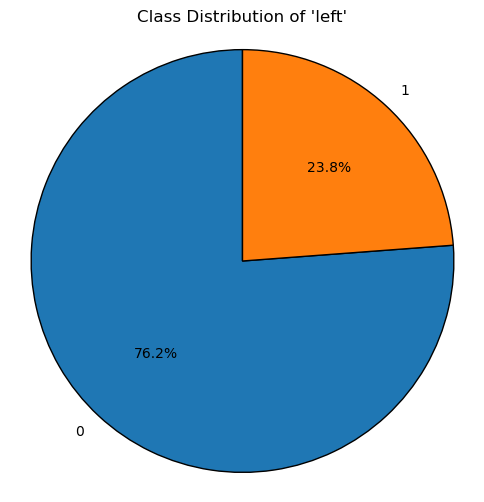

In [55]:
# check for imbalanced class data.  In this case the original feature is 'left'.  
# From what I infer, for when the employee left the value is 1.  If they did not leave, the value is 0.
class_counts = df['left'].value_counts()
print(class_counts)

class_counts = df['left'].value_counts()
labels = class_counts.index.astype(str)  # Convert index to string for labeling

# Create the pie chart:
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Class Distribution of 'left'")
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()     

# Observations from plot
# The class 'left' is clearly imbalanced, which can cause our model to be biased toward the majority class.
# I will use SMOTE to balance the classes, but only on the training data to prevent data leakage.
# Before applying SMOTE, I'll split the data into training and testing sets.
# I will then scale the numeric feature columns ( using StandardScaler) so that they fall between 0 and 1.

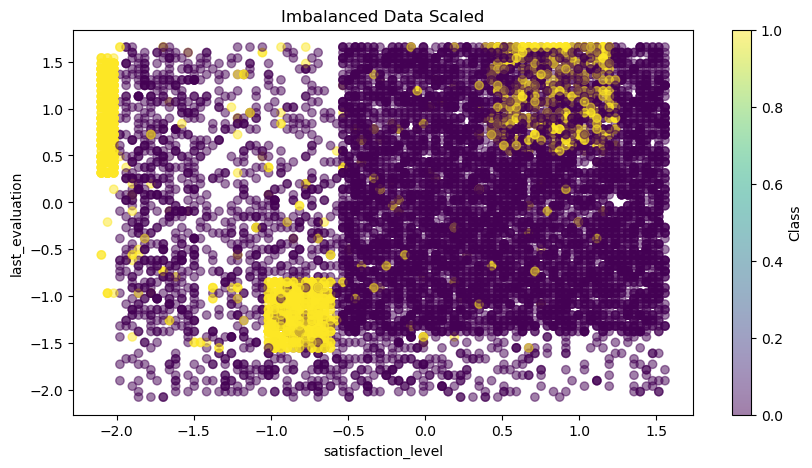

In [56]:
# Split the data into training and testing and scale the features

# Separate features and target variable
X = df.drop('left', axis=1)
y = df['left']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature variables
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns)

# Now plot using the actual feature names
plt.figure(figsize=(10, 5))
plt.scatter(X_train_sc_df.iloc[:, 0], X_train_sc_df.iloc[:, 1], c=y_train, alpha=0.5, cmap='viridis', marker='o')
plt.title('Imbalanced Data Scaled')
plt.xlabel(X_train_sc_df.columns[0])
plt.ylabel(X_train_sc_df.columns[1])
plt.colorbar(label='Class')
plt.show()





In [57]:
## Handle the left Class Imbalance using the SMOTE technique. 

# Pre-process the data by converting categorical columns to numerical columns by: 

# Separating categorical variables and numeric variables 

# Applying get_dummies() to the categorical variables 

# Combining categorical variables and numeric variables 

# Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123. 

# Upsample the train dataset using the SMOTE technique from the imblearn module.


In [58]:
# NOTE:
# The categorical features have already been converted to numerical values in order to do the heatmap earlier
# The data has been split into training and test sets.
# Now proceed to balance the training data using SMOTE.

from imblearn.over_sampling import SMOTE

# Apply SMOTE only on the training data (assume X_train and y_train are already defined and pre-processed)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Original training set class distribution:")
print(y_train.value_counts())

print("\nResampled training set class distribution:")
print(pd.Series(y_train_res).value_counts())


Original training set class distribution:
left
0    9134
1    2865
Name: count, dtype: int64

Resampled training set class distribution:
left
0    9134
1    9134
Name: count, dtype: int64


In [59]:
# Perform 5-fold cross-validation model training and evaluate performance. 

# Train a logistic regression model, apply a 5-fold CV, and plot the classification report. 

# Train a Random Forest Classifier model, apply the 5-fold CV, and plot the classification report. 

# Train a Gradient Boosting Classifier model, apply the 5-fold CV, and plot the classification report. 

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78      9134
           1       0.77      0.83      0.80      9134

    accuracy                           0.79     18268
   macro avg       0.79      0.79      0.79     18268
weighted avg       0.79      0.79      0.79     18268



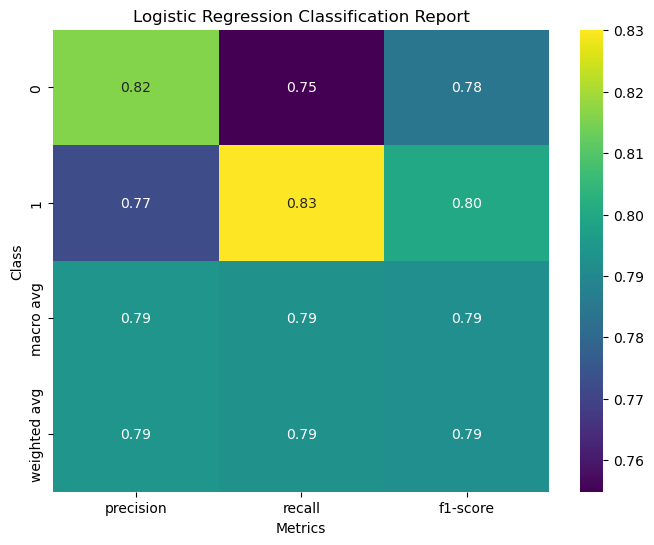

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9134
           1       0.99      0.97      0.98      9134

    accuracy                           0.98     18268
   macro avg       0.98      0.98      0.98     18268
weighted avg       0.98      0.98      0.98     18268



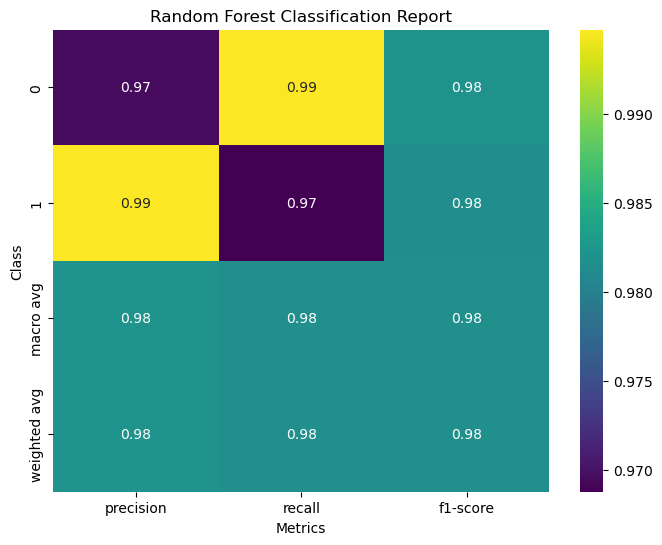

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      9134
           1       0.97      0.94      0.96      9134

    accuracy                           0.96     18268
   macro avg       0.96      0.96      0.96     18268
weighted avg       0.96      0.96      0.96     18268



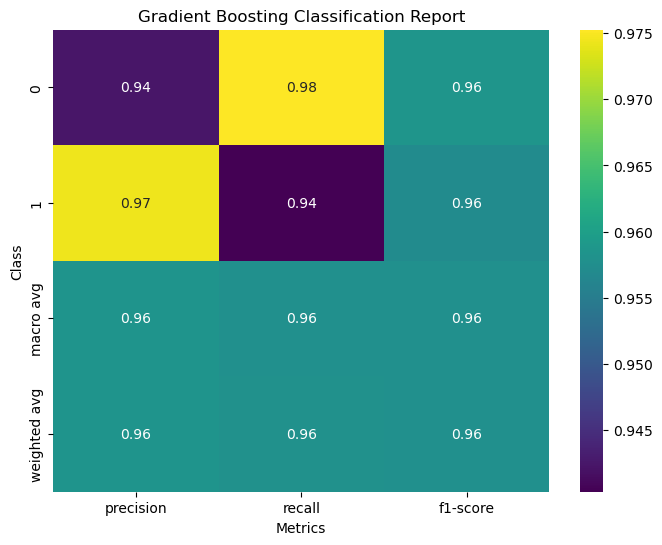

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict

# Define a helper function to plot the classification report as a heatmap.
def plot_classification_report(report_dict, title):
    # Convert the report dictionary into a DataFrame.
    df_report = pd.DataFrame(report_dict).transpose()
    # We'll drop the "accuracy" row if present to focus on class-specific metrics.
    if 'accuracy' in df_report.index:
        df_report = df_report.drop('accuracy')
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_report.iloc[:, :3], annot=True, fmt=".2f", cmap="viridis")  
    # Here, iloc[:, :3] selects the first three columns (precision, recall, f1-score)
    plt.title(title)
    plt.ylabel("Class")
    plt.xlabel("Metrics")
    plt.show()

# ------------------------------
# Model 1: Logistic Regression
# ------------------------------
lr = LogisticRegression(random_state=42, max_iter=1000)
y_pred_lr = cross_val_predict(lr, X_train_res, y_train_res, cv=5)

# Generate and print the classification report.
report_lr = classification_report(y_train_res, y_pred_lr, output_dict=True)
print("Logistic Regression Classification Report:")
print(classification_report(y_train_res, y_pred_lr))
# Plot the report as a heatmap.
plot_classification_report(report_lr, "Logistic Regression Classification Report")

# ------------------------------
# Model 2: Random Forest Classifier
# ------------------------------
rf = RandomForestClassifier(random_state=42)
y_pred_rf = cross_val_predict(rf, X_train_res, y_train_res, cv=5)

report_rf = classification_report(y_train_res, y_pred_rf, output_dict=True)
print("Random Forest Classification Report:")
print(classification_report(y_train_res, y_pred_rf))
plot_classification_report(report_rf, "Random Forest Classification Report")

# ------------------------------
# Model 3: Gradient Boosting Classifier
# ------------------------------
gb = GradientBoostingClassifier(random_state=42)
y_pred_gb = cross_val_predict(gb, X_train_res, y_train_res, cv=5)

report_gb = classification_report(y_train_res, y_pred_gb, output_dict=True)
print("Gradient Boosting Classification Report:")
print(classification_report(y_train_res, y_pred_gb))
plot_classification_report(report_gb, "Gradient Boosting Classification Report")

# Observations from the output below
# Wow what a difference between the accuracy of the logistic regression vs the random forest and gradient boosting models.
# This was an interesting excercise.  Looking back to the original observations of correlation of other features to whether the employee 'left'
# It now seems obvious to me that since there was not a strong linear relationship, logistic regression is not the best algorithm to choose for the model.
# Both Random Forest and Gradient Boosting are decision-based models so maybe they are better for predicting outcome of a class when little linear correlation exists with the other features.
# Logistic Regression was sort of loser with an overall accuracy of 79%. I would like to understand why there is such a variance and flip flop
# between the precision and recall for class 0 (employees who stayed) and class 1 (employees who left)

# The winner is the Random Forest with an overall accuracy of 98% and it stands out in comparison to the logistic regression at 79% accuracy
# And random forest did not seem to compromise on precision or recall for either of the classes.  So only 1-3% false positives and false negatives 
# in predicting whether the employee stayed or left the company.

# Second place goes to Gradient Boosting with an overall accuracy of 96% with a slight trade-off for error types between classes.  
# Class 0 has slightly higher recall and Class 1 has slightly higher precision.  So this would mean more of a likelihood for false positives
# for predictions on the employee staying and more likelihood for false negatives for the employee leaving.

# Overall conclusion is that Random Forest is the best model because of it's overall accuracy AND better precision and recall compared to the other 2.
# Random Forest will most accurately predict whether an employee will leave or stay based on data provided.

In [61]:
# Identify the best model and justify the evaluation metrics used. 

# Find the ROC/AUC for each model and plot the ROC curve. 

# Find the confusion matrix for each of the models. 

# Explain which metric needs to be used from the confusion matrix: Recall or Precision? 

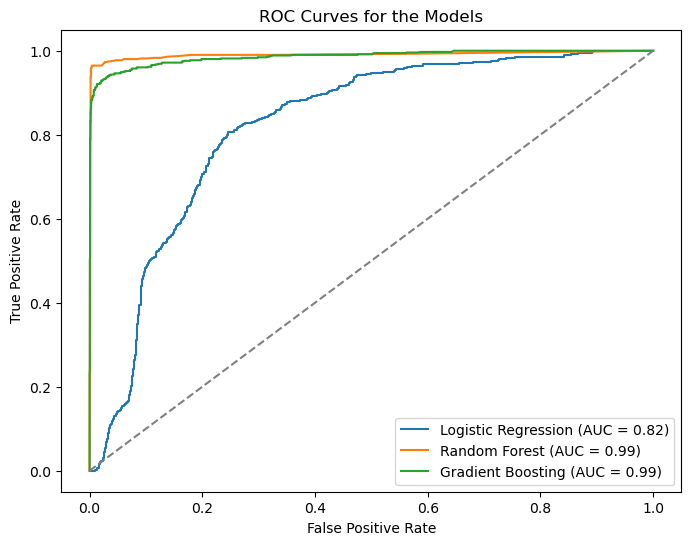

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define a helper function to plot the ROC curve for a given model.
def plot_roc_curve(model, X_test, y_test, label):
    # The model should support predict_proba; we take the probabilities for the positive class.
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')
    
# Fit each model on the SMOTE-balanced training data and compute ROC on the test set.

# Logistic Regression
lr.fit(X_train_res, y_train_res)
# Get test-set predictions (for confusion matrix later)
y_pred_lr_test = lr.predict(X_test)
# Plot ROC curve
plt.figure(figsize=(8,6))
plot_roc_curve(lr, X_test, y_test, "Logistic Regression")

# Random Forest
rf.fit(X_train_res, y_train_res)
y_pred_rf_test = rf.predict(X_test)
plot_roc_curve(rf, X_test, y_test, "Random Forest")

# Gradient Boosting
gb.fit(X_train_res, y_train_res)
y_pred_gb_test = gb.predict(X_test)
plot_roc_curve(gb, X_test, y_test, "Gradient Boosting")

# Add the random chance line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for the Models")
plt.legend(loc="lower right")
plt.show()

# Observations on the ROC Curves:

# The ROC curves visually confirm the data we saw in the classification reports. 
# Both the Random Forest and Gradient Boosting models have ROC curves that are far from the diagonal line,
# indicating that they achieve high True Positive Rates while maintaining low False Positive Rates.

# In contrast, the ROC curve for Logistic Regression is closer to the diagonal, which means its performance, 
# as measured by the Area Under the Curve (AUC), is notably lower (.82) compared to the near-perfect AUCs (.99) 
# of Random Forest and Gradient Boosting.

# The AUC essentially represents the probability that a randomly chosen positive case is ranked higher 
# than a randomly chosen negative case. Since Logistic Regression's ROC curve encloses less area, 
# this aligns with its lower overall ability to distinguish between classes.


Confusion Matrix - Logistic Regression:
[[1741  553]
 [ 147  559]]

Confusion Matrix - Random Forest:
[[2280   14]
 [  25  681]]

Confusion Matrix - Gradient Boosting:
[[2236   58]
 [  48  658]]


<Figure size 600x400 with 0 Axes>

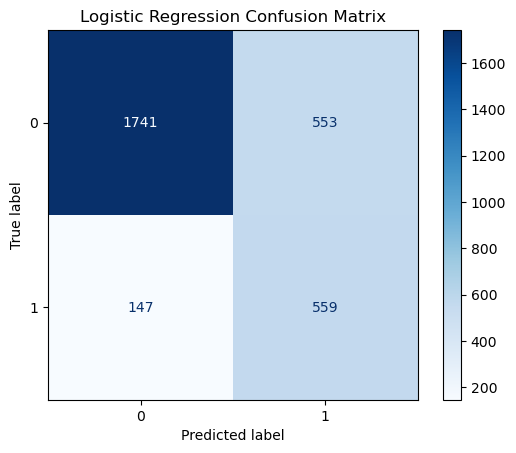

<Figure size 600x400 with 0 Axes>

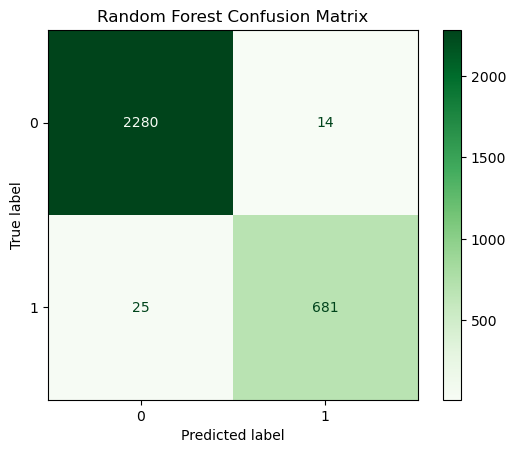

<Figure size 600x400 with 0 Axes>

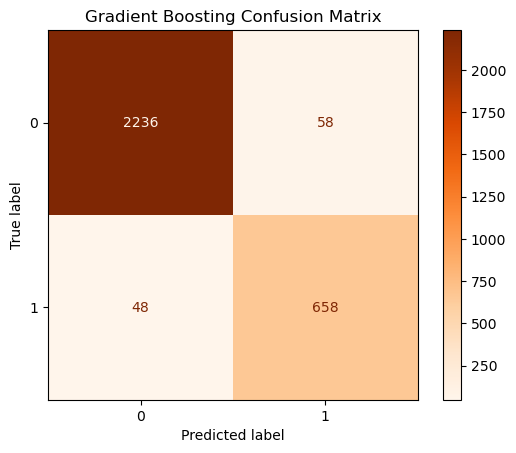

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr_test)
cm_rf = confusion_matrix(y_test, y_pred_rf_test)
cm_gb = confusion_matrix(y_test, y_pred_gb_test)

# Print the confusion matrices
print("Confusion Matrix - Logistic Regression:")
print(cm_lr)
print("\nConfusion Matrix - Random Forest:")
print(cm_rf)
print("\nConfusion Matrix - Gradient Boosting:")
print(cm_gb)

# Plot the confusion matrices using ConfusionMatrixDisplay
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_gb = ConfusionMatrixDisplay(confusion_matrix=cm_gb)

plt.figure(figsize=(6,4))
disp_lr.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

plt.figure(figsize=(6,4))
disp_rf.plot(cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.figure(figsize=(6,4))
disp_gb.plot(cmap='Oranges')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# Observations from Confusion Matrices for each of the models in output below:

# Logisitic Regression had 1741 True Negatives, 553 False Positives, 147 False Negatives and 559 True Positives. 
# (2300 correct and 700 incorrect)  Recall for class 1 (those who left) TP/TP+FN = 79.2%. Precision TP/TP+FP = 50.2%

# Random Forest had 2280 True Negatives, 14 False Positives, 25 False Negatives, and 681 True Positives. 
# (2961 correct and 39 incorrect) Recall for class 1 TP/TP+FN = 96.5%. Precision TP/TP+FP = 98%

# Gradient Boosting had 2236 True Negatives, 58 False Positives, 48 False Negatives and 658 True Positives.
# (2894 correct and 106 incorrect) Recall for class 1 TP/TP+FN = 93.2%. Precision TP/TP+FP = 91.9%

# This is the most interesting part of the process so far because these performance metrics for the confusion matrices are on the actual test
# set which has the unbalanced class data because it was excluded from SMOTE performed on training set.

# In this performance data, the Random Forest stands out even better than it did on the training set as it compares to the other two models.
# Clearly the Random Forest is capturing some complexity in the relationships between some of the other features which was not evident
# in the initial correlation heatmap of all the variables.

In [64]:
# Suggest various retention strategies for targeted employees. 

# Using the best model, predict the probability of employee turnover in the test data. 

# Based on the probability score range below, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone. 

# Safe Zone (Green) (Score < 20%) 

# Low-Risk Zone (Yellow) (20% < Score < 60%) 

# Medium-Risk Zone (Orange) (60% < Score < 90%) 

# High-Risk Zone (Red) (Score > 90%).

In [65]:
# Predict the probability of turnover for the positive class (class 1)
y_proba = rf.predict_proba(X_test)[:, 1]  # use the probability of the positive class

# Create a DataFrame to organize probabilities and assign risk zones
df_predictions = pd.DataFrame({
    'probability': y_proba
}, index=X_test.index)


In [66]:
def assign_zone(prob):
    if prob < 0.20:
        return "Safe (Green)"
    elif 0.20 <= prob < 0.60:
        return "Low-Risk (Yellow)"
    elif 0.60 <= prob < 0.90:
        return "Medium-Risk (Orange)"
    else:  # prob >= 0.90
        return "High-Risk (Red)"

df_predictions['risk_zone'] = df_predictions['probability'].apply(assign_zone)

# Display the first few predictions to see the output
print(df_predictions.head())

# Optionally, count the number of employees in each zone
print("\nNumber of employees per risk zone:")
print(df_predictions['risk_zone'].value_counts())


      probability        risk_zone
6723         0.01     Safe (Green)
6473         0.01     Safe (Green)
4679         0.06     Safe (Green)
862          1.00  High-Risk (Red)
7286         0.00     Safe (Green)

Number of employees per risk zone:
risk_zone
Safe (Green)            2198
High-Risk (Red)          647
Low-Risk (Yellow)        112
Medium-Risk (Orange)      43
Name: count, dtype: int64


In [67]:
print(df.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')


In [68]:
# Show which department most of the high risk employees are in

# Add the department information to the predictions
df_predictions['department'] = df['sales']  # This pulls the 'sales' column from the original df

# Filter for high-risk employees
df_high_risk = df_predictions[df_predictions['risk_zone'] == "High-Risk (Red)"]

# Group by the 'department' column and count the number of high-risk employees per department
high_risk_by_dept = df_high_risk.groupby('department').size().reset_index(name='count')

print("Number of high-risk employees per department:")
print(high_risk_by_dept)

Number of high-risk employees per department:
   department  count
0           0     50
1           1     26
2           2     35
3           3     45
4           4     14
5           5     36
6           6     23
7           7    182
8           8    112
9           9    124


In [70]:
# The report above would not be useful if we didn't know the corresponding department names with the numbers from when it was transformed.

# Merge the risk predictions with the original department names
# We assume the indices match between df_predictions and df_dept.
df_predictions = df_predictions.copy()  # so to not modify the original
df_predictions['department'] = df_dept['department'].loc[df_predictions.index]

# Now you can filter for high-risk employees and group by department
df_high_risk = df_predictions[df_predictions['risk_zone'] == "High-Risk (Red)"]

# Group by department and count the number of high-risk employees
high_risk_by_dept = df_high_risk.groupby('department').size().reset_index(name='count')
high_risk_by_dept = high_risk_by_dept.sort_values(by='count', ascending=False)

print(high_risk_by_dept)


    department  count
7        sales    182
9    technical    124
8      support    112
0           IT     50
3           hr     45
5    marketing     36
2   accounting     35
1        RandD     26
6  product_mng     23
4   management     14


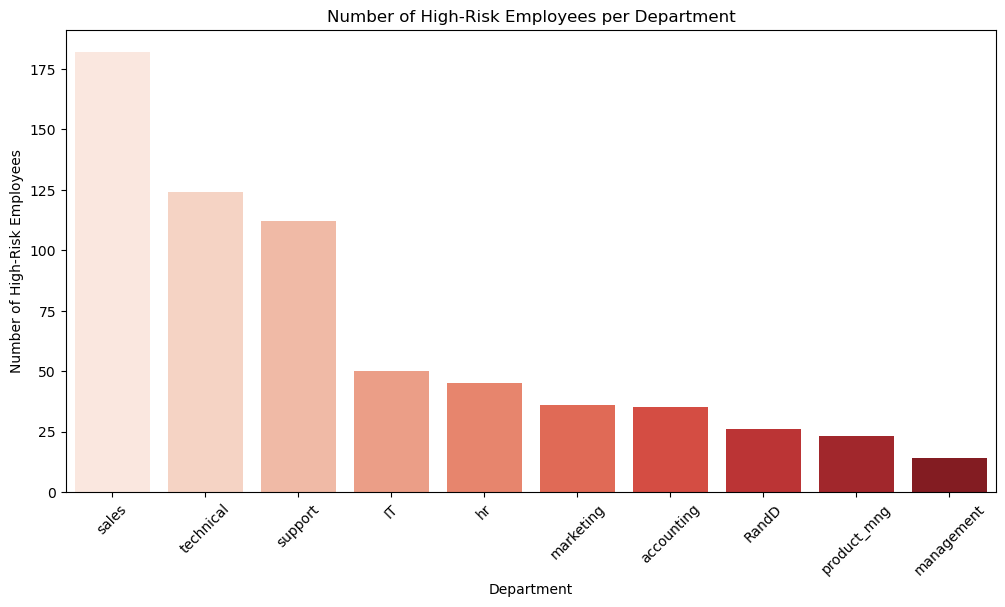

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=high_risk_by_dept, x='department', y='count', hue='department', palette='Reds', dodge=False)
# Remove redundant legend

plt.title('Number of High-Risk Employees per Department')
plt.xlabel('Department')
plt.ylabel('Number of High-Risk Employees')
plt.xticks(rotation=45)
plt.show()


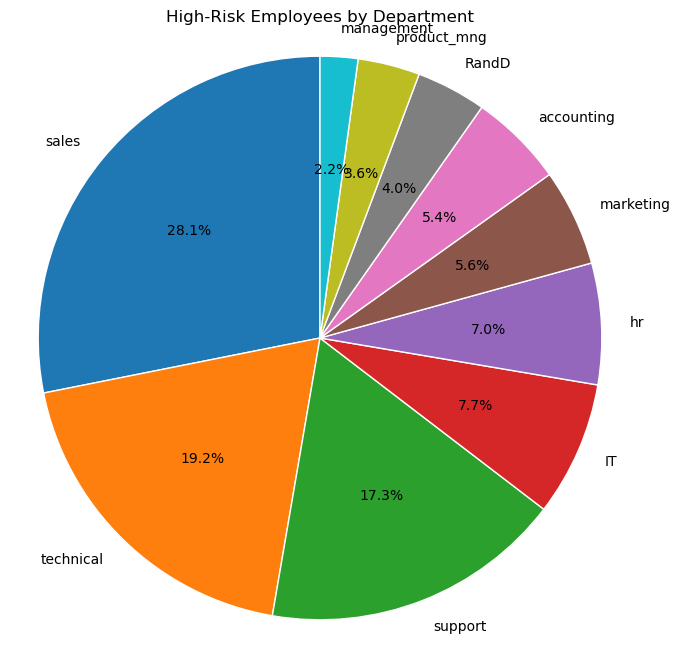

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(
    high_risk_by_dept['count'],
    labels=high_risk_by_dept['department'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
plt.title('High-Risk Employees by Department')
plt.axis('equal')  #  pie chart is a circle.
plt.show()
